# Hairball

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig5/main/'

### Get the TFs

In [5]:
tf_df = pd.read_csv('../DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tf_df = tf_df[tf_df['Is a GO TF?'] == 'Yes']

tfs = tf_df['HGNC symbol'].tolist()

In [6]:
filtered_tfs = """MAFG
SPI1
ZNF655
MAX
ATF4
ATF3
IRF2
IRF1
ARID5A
BACH1
YY1
HMGA1
IRF7
STAT1
NR1H2
XBP1
ETV6
MSC
ATF5
MAFB
FOS
CEBPB
BBX
STAT3
REL
JUN
CEBPD
DDIT3
NR3C1
TGIF1
ZNF267
NFE2L2
HIF1A
AHR
GTF2B
CREM
HBP1
RELB
TFEC
YBX1
ELF1
JUNB
NFKB1
IRF9
RBPJ
KLF6""".split()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [8]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
adata.shape

(69958, 36588)

### Setup memento

In [10]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [11]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [12]:
memento.setup_memento(adata, q_column='q', trim_percent=0.05)

### Grab DE genes

In [13]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [14]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200320.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [15]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

In [16]:
ciliated_beta = all_result['ciliated']['ht']['beta']['6']
ciliated_gamma = all_result['ciliated']['ht']['gamma']['6']
ciliated_lambda = all_result['ciliated']['ht']['lambda']['6']

In [17]:
print('Number of DE genes', ciliated_beta.query('de_fdr < 0.01').shape[0])
print('Number of DV genes', ciliated_beta.query('dv_fdr < 0.1').shape[0])

Number of DE genes 3776
Number of DV genes 761


In [18]:
de_genes = ciliated_beta.query('de_fdr < 0.01 & de_coef > 0').gene.tolist()

In [156]:
'SRSF2' in de_genes

True

### Get DC genes 

In [19]:
beta_dc_result = pd.read_csv(data_path + 'beta_dc_result.csv')

In [146]:
beta_dc_result_corrected.query('gene_2 == "SRSF2"')

gene_1 gene_2  corr_coef   corr_se  corr_pval  corr_fdr
28863  HIF1A  SRSF2  -0.136678  0.347268   0.709129  0.838250
78556    MAX  SRSF2   0.313272  0.265140   0.231577  0.656735
40381  BACH1  SRSF2   0.120279  0.225133   0.590341  0.743250
15784    YY1  SRSF2   0.348865  0.185107   0.059694  0.473792
55532   YBX1  SRSF2  -0.124104  0.137886   0.369063  0.598135
23481   ELF1  SRSF2   0.469108  0.195485   0.016098  0.111691
42435  STAT1  SRSF2   0.404729  0.144787   0.005799  0.023651
25949  STAT3  SRSF2   0.353703  0.198986   0.077592  0.300477

In [20]:
subset_list = []
for tf in tfs:
    
    subset = beta_dc_result.query('gene_1 == "{}"'.format(tf)).copy()
    if subset.shape[0] == 0:
        continue
    subset['corr_fdr'] = memento.util._fdrcorrect(subset['corr_pval'])
    subset_list.append(subset)

In [21]:
beta_dc_result_corrected = pd.concat(subset_list)

In [22]:
beta_dc_result_corrected.query('gene_2.str.contains("HLA")', engine='python').query('gene_1 == "STAT1"')

gene_1   gene_2  corr_coef   corr_se  corr_pval  corr_fdr
41390  STAT1    HLA-F   0.370991  0.141460   0.009399  0.032829
41391  STAT1    HLA-A   0.387095  0.085245   0.000563  0.009477
41393  STAT1    HLA-E   0.299332  0.107449   0.007299  0.027752
41398  STAT1    HLA-C   0.351479  0.080835   0.000274  0.009183
41399  STAT1    HLA-B   0.406874  0.076269   0.000057  0.008709
41408  STAT1  HLA-DRA   0.335896  0.067685   0.000297  0.009183
41414  STAT1  HLA-DMB   0.204315  0.170421   0.228277  0.325898
41415  STAT1  HLA-DMA   0.260400  0.103428   0.011399  0.037996

In [23]:
dc_pairs = beta_dc_result_corrected.query('corr_fdr < 0.05').copy()

In [147]:
dc_pairs.query('gene_2 == "SRSF2"')

gene_1 gene_2  corr_coef   corr_se  corr_pval  corr_fdr    dc
42435  STAT1  SRSF2   0.404729  0.144787   0.005799  0.023651  True

### Compute correlations

In [24]:
adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control', 'beta']), :].copy()
adata_stim.obs['group'] = 'A'

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [25]:
memento.create_groups(adata_stim, label_columns=['donor', 'time'])

In [26]:
memento.compute_1d_moments(adata_stim, min_perc_group=.9)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


In [27]:
tfs = list(set(filtered_tfs) & set(adata_stim.var.index))

In [28]:
de_genes = list(set(de_genes) & set(adata_stim.var.index))
memento.compute_2d_moments(adata_stim, list(itertools.product(tfs, adata_stim.var.index.tolist())))

### Construct network

In [157]:
moment_df = memento.get_2d_moments(adata_stim, groupby='time')[['gene_1', 'gene_2']+['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]].query('gene_1 != gene_2')

In [158]:
moment_df['max_corr'] = moment_df[['time_'+str(i) for i in [0, 3, 6, 9, 24,48]]].max(axis=1)
moment_df['min_corr'] = moment_df[['time_'+str(i) for i in [0, 3, 6, 9, 24,48]]].min(axis=1)

moment_df['mean_corr'] = moment_df[['time_'+str(i) for i in [0, 3, 6, 9, 24,48]]].mean(axis=1)
moment_df['var_corr'] = moment_df[['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]].std(axis=1)
moment_df['diff'] = moment_df['time_6'] - moment_df['time_0']

In [159]:
num_pairs_all = moment_df.shape[0]

top_edge_sets = {}

for time in [0, 3]:
    
    top_edge_sets[time] = moment_df.query('gene_1 != gene_2').sort_values('time_' + str(time), ascending=False).head(int(0.007*num_pairs_all))[['gene_1', 'gene_2']]

In [160]:
dc_pairs['dc'] = True

In [161]:
moment_df = moment_df.merge(dc_pairs[['gene_1', 'gene_2', 'dc']], on=['gene_1', 'gene_2'], how='left').fillna(False)

In [162]:
moment_df['high_min_corr'] = moment_df['min_corr'] > 0.4
moment_df['high_diff'] = moment_df['diff'] > 0.5

In [163]:
moment_df['dc_de'] = moment_df['dc'] & moment_df['gene_2'].isin(de_genes)
moment_df['de'] = moment_df['gene_2'].isin(de_genes)

In [164]:
moment_df.query('(dc & (gene_2 in @de_genes))').shape

(1108, 18)

In [165]:
moment_df.query('high_min_corr | (dc & (gene_2 in @de_genes))').shape

(2588, 18)

In [166]:
moment_df.query('high_min_corr | high_diff').shape

(9407, 18)

In [167]:
filtered_moment_df = moment_df.query('high_min_corr | (dc & (gene_2 in @de_genes))').copy()

In [168]:
def classify_row(row):
    
    if row['dc_de']:
        return 'dc_de'
    elif row['de']:
        return 'de'
    else:
        return 'rest'

In [169]:
filtered_moment_df['class'] = filtered_moment_df.apply(classify_row, axis=1)

In [170]:
ifn_tfs = ["IRF1", "IRF7", "IRF9", "STAT1"]

In [171]:
filtered_moment_df['TF'] = 1

In [172]:
print(filtered_moment_df.shape)

(2588, 20)


### Attach non-canonical ISG labels

In [173]:
label_df = pd.read_csv(data_path + 'noncanon_isg.csv')

In [174]:
label_df.head(5)

gene_1      gene_2    time_0    time_3    time_6    time_9   time_24  \
0  STAT1       PSMF1 -0.159518  0.418939  0.539422  0.530408  0.726924   
1  STAT1  AC025171.2  0.004094  0.137387  0.158361  0.216929  0.240675   
2  STAT1        FRYL  0.207863  0.214549  0.234645  0.240139  0.297792   
3  STAT1      KDELR2  0.072182  0.251713  0.307713  0.090105  0.173279   
4  STAT1       IFI44  0.710457  0.729412  0.771649  0.809101  0.791485   

    time_48     nc      c  
0  0.092050   True  False  
1  0.161308  False  False  
2  0.283896  False  False  
3  0.202696  False  False  
4  0.707354  False   True

In [175]:
nc_isgs = label_df.query('nc').gene_2.tolist()
c_isgs = label_df.query('c').gene_2.tolist()

In [176]:
'SRSF2' in nc_isgs

True

In [177]:
filtered_moment_df.query('gene_2 == "SRSF2"')

gene_1 gene_2    time_0    time_3    time_6    time_9   time_24  \
116994   YBX1  SRSF2  0.546853  0.457204  0.479375  0.447749  0.467481   
334640  STAT1  SRSF2  0.166384  0.421232  0.483469  0.475475  0.473107   

         time_48  max_corr  min_corr  mean_corr  var_corr      diff     dc  \
116994  0.532712  0.546853  0.447749   0.488562  0.041292 -0.067478  False   
334640  0.608723  0.608723  0.166384   0.438065  0.146906  0.317084   True   

        high_min_corr  high_diff  dc_de    de  class  TF  
116994           True      False  False  True     de   1  
334640          False      False   True  True  dc_de   1

In [178]:
def classify_row(row):
    
    if row['gene_2'] in c_isgs:
        return 'c'
    elif row['gene_2'] in nc_isgs:
        return 'nc'
    else:
        return 'rest'

In [179]:
filtered_moment_df['class'] = filtered_moment_df.apply(classify_row, axis=1)

In [183]:
filtered_moment_df.query('gene_2 == "KPNB1"')

gene_1 gene_2   time_0    time_3    time_6    time_9   time_24  \
334467  STAT1  KPNB1  0.01051  0.599064  0.574941  0.675314  0.766208   

         time_48  max_corr  min_corr  mean_corr  var_corr      diff    dc  \
334467  0.609839  0.766208   0.01051   0.539313  0.268113  0.564431  True   

        high_min_corr  high_diff  dc_de    de class  TF  
334467          False       True   True  True    nc   1

In [180]:
filtered_moment_df.to_csv('filtered_edges_mincorr_dc.csv', index=False)

### Create igraph

In [49]:
import igraph
from igraph import plot

In [41]:
df = moment_df[['gene_1', 'gene_2', 'time_3']]

In [42]:
tuples = [tuple(x) for x in df.values]

In [51]:
g = igraph.Graph.TupleList(tuples, directed = False, edge_attrs = ['weight'])

In [77]:
# layout = g.layout('drl')
layout2 = g.layout('large')

In [68]:
import matplotlib.cm as cm
from matplotlib.colors import TwoSlopeNorm

cmap = cm.viridis
norm = Normalize(vmin=0, vmax=1)
print(cmap(norm(-0)))

(0.267004, 0.004874, 0.329415, 1.0)


In [78]:
plot(
    g, 
    layout=layout2,
    vertex_size=0,
    edge_color=[cmap(norm(x)) for x in g.es['weight']])

### Clustering?

In [123]:
heatmap_dfs = {}
for time in ['0', '3', '6', '9', '24', '48']:
    heatmap_dfs[time] = pd.DataFrame(np.zeros((len(tfs), len(de_genes))), index=tfs, columns=de_genes).T

In [124]:
for idx, row in moment_df.iterrows():
    for time in ['0', '3', '6', '9', '24', '48']:
        heatmap_dfs[time].loc[row['gene_2'], row['gene_1']] = row['time_{}'.format(time)]

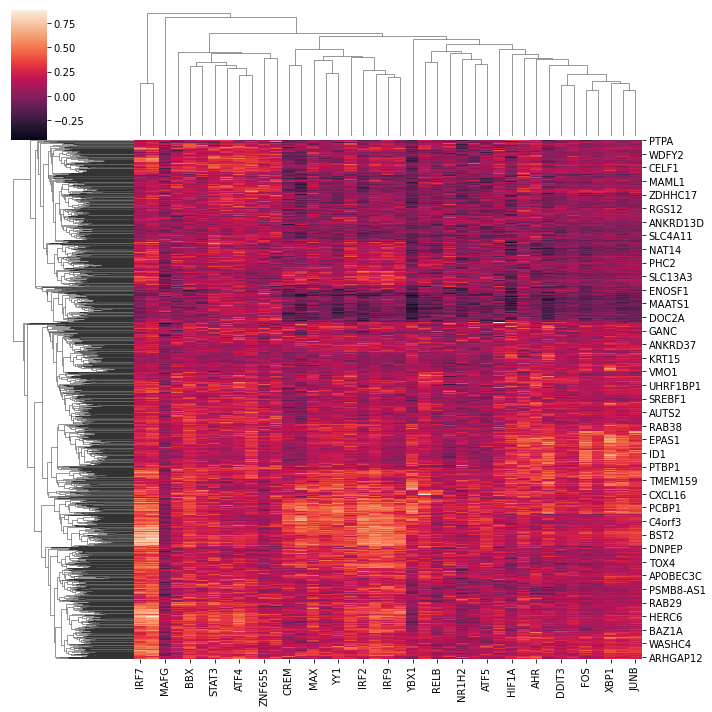

In [151]:
cg = sns.clustermap(heatmap_dfs['3']);
# plt.close()

In [148]:
tf_order = heatmap_df.columns[cg.dendrogram_col.reordered_ind].tolist()
gene_order = heatmap_df.index[cg.dendrogram_row.reordered_ind].tolist()

In [149]:
a = heatmap_df.loc[gene_order, :]

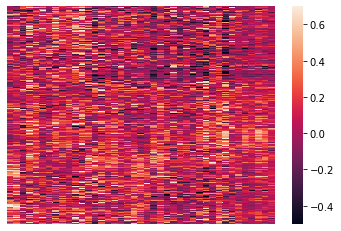

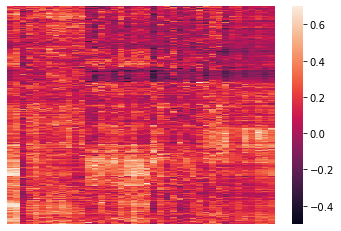

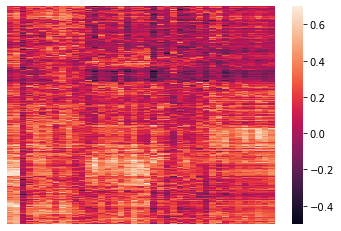

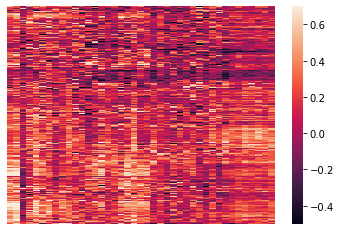

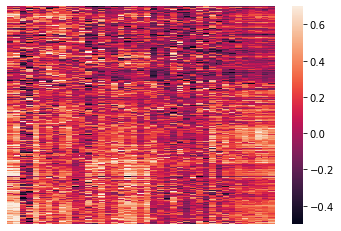

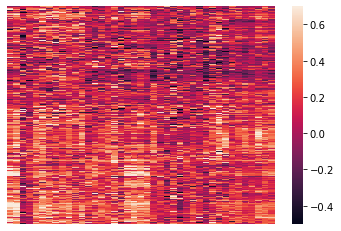

In [150]:
for time in ['0', '3', '6', '9', '24', '48']:
    plt.figure()
    sns.heatmap(heatmap_dfs[time].loc[gene_order, :].loc[:, tf_order], vmin=-0.5, vmax=0.7)
    plt.axis('off')

In [38]:
moment_df.shape

(18850, 10)

In [39]:
!pip install py2cytoscape

     |████████████████████████████████| 57 kB 1.8 MB/s eta 0:00:011
     |████████████████████████████████| 278 kB 2.9 MB/s eta 0:00:01
  Created wheel for py2cytoscape: filename=py2cytoscape-0.7.1-py3-none-any.whl size=78811 sha256=be423ddcc76b6408e779a39df50437ab4251b08acedd4b059b413f710cd844a4
  Stored in directory: /home/ssm-user/.cache/pip/wheels/5c/c3/5b/76436ed5d5c54edcb37239175c9e978c7994ffc9f9b5f8472a
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=73ebd5dc27eec78fb93142a4e0386e9b80ddc0d5dd38316da8318e3643058e7e
  Stored in directory: /home/ssm-user/.cache/pip/wheels/fe/cd/78/a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built py2cytoscape pydotplus


### Draw network

In [138]:
moment_df

gene_1    gene_2    time_0    time_3    time_6    time_9   time_24  \
2210   IRF7    ZNF117  0.509409  0.059942 -0.125539 -0.228515  0.394727   
2350   IRF7    ZNF274  0.701238  0.225473  0.079529 -0.019809 -0.050401   
1260  STAT1  UHRF1BP1  0.802499  0.340098  0.192829  0.409275  0.250397   
10    STAT1     SBNO2  0.711389  0.390954  0.126273  0.182214  0.215674   
4025   IRF9    BTN2A1  0.586752  0.105627  0.020490  0.139511 -0.155333   
...     ...       ...       ...       ...       ...       ...       ...   
2358   IRF7      AFF1 -0.279018  0.264135  0.385862  0.378699  0.716724   
1404  STAT1   SLC44A1 -0.058193  0.413500  0.626843  0.761874  0.610771   
1568   IRF7    DAB2IP -0.312938  0.310283  0.373963  0.358779  0.586677   
2780   IRF7      AZI2 -0.275647  0.347439  0.423486  0.584554  0.537752   
4167   IRF9   TMEM187 -0.372106  0.313650  0.428325 -0.012377  0.613849   

       time_48  max_corr      diff  
2210 -0.132296  0.509409 -0.634949  
2350  0.057734  0.701238 -0.621709  
1260  0.252184  0.802499 -0.609670  
10    0.208296  0.711389 -0.585116  
4025 -0.021664  0.586752 -0.566262  
...        ...       ...       ...  
2358  0.486672  0.716724  0.664880  
1404  0.405393  0.761874  0.685036  
1568  0.376880  0.586677  0.686901  
2780  0.335689  0.584554  0.699133  
4167  0.261524  0.613849  0.800431  

[2515 rows x 10 columns]

### Compute baseline correlations

In [64]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()
adata_ctrl.obs['group'] = 'A'

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [65]:
'IRF7' in adata_ctrl.var.index

True

In [76]:
'IRF7' in expr_tfs

True

In [75]:
expr_tfs = list(set(tfs) & set(adata_ctrl.var.index))
de_genes = list(set(de_genes) & set(adata_ctrl.var.index))

In [71]:
ctrl_corrs = memento.get_2d_moments(adata_ctrl, groupby='ALL')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/main.py:594: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [87]:
mean_ctrl_corrs = ctrl_corrs.dropna().groupby('gene_1')['ALL_sg'].mean()#.reset_index().sort_values('ALL_sg', ascending=False).head(30)

### Compute TF mean corrs

In [20]:
def get_2d_moments(tf, adata_stim):
    
    if tf not in adata_stim.var.index.tolist():
        return None

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
    return moment_df

def get_corr_diffs(stim):
    
    adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control', stim]) & \
    adata.obs.time.isin(['3','0'])].copy()

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')
    
    tf_df_list = []
    for idx, tf in enumerate(filtered_tfs):

        df = get_2d_moments(tf, adata_stim)
        if df is None:
            continue
        diff = (df['time_3'] - df['time_0']).mean()
        tf_df_list.append((tf, diff))
        del df

    tf_df = pd.DataFrame(tf_df_list, columns=['tf', 'diff']).sort_values('diff', ascending=False)
    tf_df['tf'] = tf_df['tf'].astype('category')
    tf_order = tf_df.sort_values('diff', ascending=False).tf.tolist()
    tf_df['tf'].cat.set_categories(tf_order, inplace=True)
    print('finished', stim)
    return tf_df

In [14]:
tf_df_alpha = get_corr_diffs('alpha')
tf_df_beta = get_corr_diffs('beta')
tf_df_gamma = get_corr_diffs('gamma')
tf_df_lambda = get_corr_diffs('lambda')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/main.py:594: RuntimeWarning: invalid value encountered in true_divide


finished alpha
finished beta
finished gamma
finished lambda


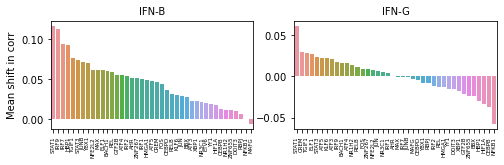

In [81]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'5.5',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1);
sns.barplot(x='tf', y='diff', data=tf_df_beta, errwidth=2)
plt.xticks(rotation=90);
plt.ylabel('Mean shift in corr')
plt.xlabel(None)
plt.title('IFN-B')

plt.subplot(1, 2, 2);
plt.title('IFN-G')

sns.barplot(x='tf', y='diff', data=tf_df_gamma, errwidth=2)
plt.xticks(rotation=90);
plt.ylabel(None)
plt.xlabel(None)
plt.savefig(fig_path + 'tf_effect_sizes.pdf', bbox_inches='tight')


### Individual examples 

IRF7, STAT1, IRF9

In [54]:
# Do beta stim first
adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control', 'beta']) & \
    adata.obs.time.isin(['3','0'])].copy()

memento.create_groups(adata_stim, label_columns=['time', 'donor'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

# STAT1 
memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
stat1_ctrl = moment_df['time_0'].values
stat1_beta = moment_df['time_3'].values

# IRF7
memento.compute_2d_moments(adata_stim, list(itertools.product(['IRF7'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
irf7_ctrl = moment_df['time_0'].values
irf7_beta = moment_df['time_3'].values

# IRF9
memento.compute_2d_moments(adata_stim, list(itertools.product(['IRF9'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
irf9_ctrl = moment_df['time_0'].values
irf9_beta = moment_df['time_3'].values

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [56]:
# gamma stim
adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control', 'gamma']) & \
    adata.obs.time.isin(['3','0'])].copy()

memento.create_groups(adata_stim, label_columns=['time', 'donor'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

# STAT1 
memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
stat1_ctrl = moment_df['time_0'].values
stat1_gamma = moment_df['time_3'].values

# IRF7
memento.compute_2d_moments(adata_stim, list(itertools.product(['IRF7'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
irf7_ctrl = moment_df['time_0'].values
irf7_gamma = moment_df['time_3'].values

# IRF9
memento.compute_2d_moments(adata_stim, list(itertools.product(['IRF9'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
irf9_ctrl = moment_df['time_0'].values
irf9_gamma = moment_df['time_3'].values

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/main.py:594: RuntimeWarning: invalid value encountered in true_divide


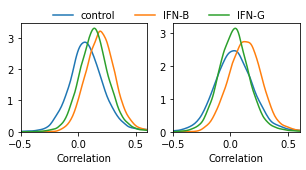

In [82]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

plt.figure(figsize=(5, 2));
plt.subplot(1, 2, 1);
sns.kdeplot(stat1_ctrl, label='control');
sns.kdeplot(stat1_beta, label='IFN-B');
sns.kdeplot(stat1_gamma, label='IFN-G');
plt.legend(loc='upper right', frameon=False, ncol=3, bbox_to_anchor=(2,1.2))
plt.xlim(-0.5, 0.6)
plt.xlabel('Correlation')
plt.ylabel(None)

plt.subplot(1, 2, 2);
sns.kdeplot(irf7_ctrl, label='control');
sns.kdeplot(irf7_beta, label='IFN-B');
sns.kdeplot(irf7_gamma, label='IFN-G');
plt.ylabel(None)
plt.xlabel('Correlation')

plt.xlim(-0.5, 0.6)
plt.savefig(fig_path + 'tf_corr_hist.pdf', bbox_inches='tight')


### Heatmap attempt

In [21]:
tf_df_alpha.head(5)

tf      diff
11  STAT1  0.192241
10   IRF7  0.161251
38   IRF9  0.151323
35   ELF1  0.143302
25  TGIF1  0.129898

In [27]:
joined = tf_df_beta \
    .merge(tf_df_gamma, on='tf', suffixes=('_beta', '_gamma'))\
    .merge(tf_df_alpha.rename(columns={'diff':'diff_alpha'}), on='tf')\
    .merge(tf_df_lambda.rename(columns={'diff':'diff_lambda'}), on='tf')
joined = joined.set_index('tf')#.clip(upper=0.07, lower=-0.07)

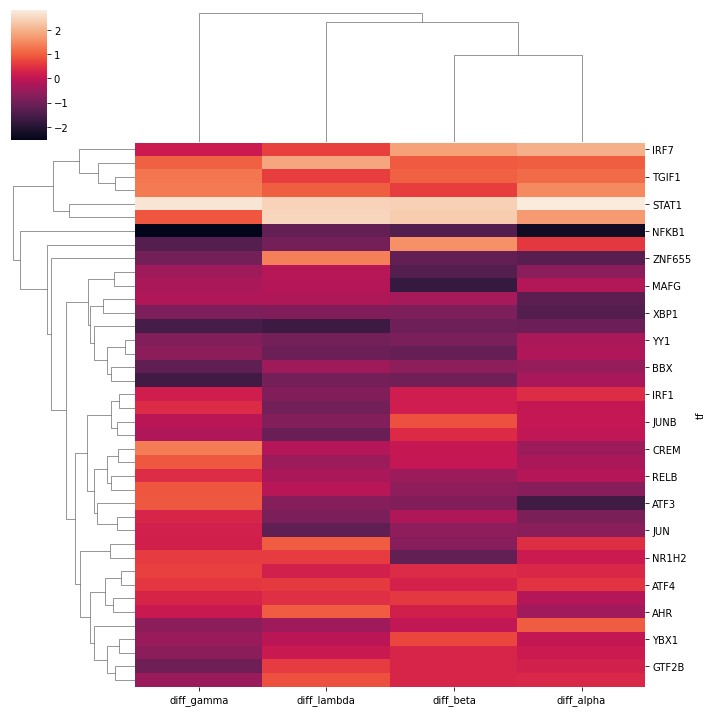

In [31]:
sns.clustermap(joined, z_score=1)

In [20]:
joined.head(5)

diff_beta  diff_gamma  diff_alpha  diff_lambda
tf                                                   
HBP1    0.188903    0.146866    0.189643     0.144297
HIF1A   0.179300    0.171330    0.186732     0.177091
BACH1   0.177841    0.161292    0.185713     0.152557
NFKB1   0.177778    0.168085    0.155215     0.164063
MAX     0.175971    0.165930    0.182030     0.179327

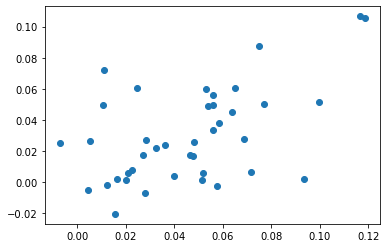

In [26]:
plt.scatter(joined['diff_beta'], joined['diff_lambda'])

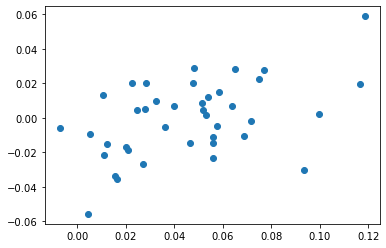

In [25]:
plt.scatter(joined['diff_beta'], joined['diff_gamma'])

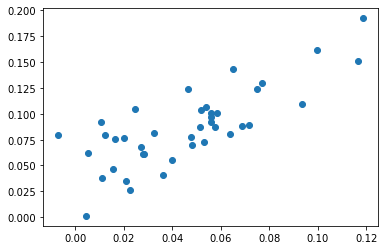

In [24]:
plt.scatter(joined['diff_beta'], joined['diff_alpha'])

In [274]:
clustered = joined.iloc[cg.dendrogram_row.reordered_ind, :].reset_index()

In [275]:
# clustered = clustered.merge(tf_df_alpha.rename(columns={'diff':'diff_alpha'}), on='tf')

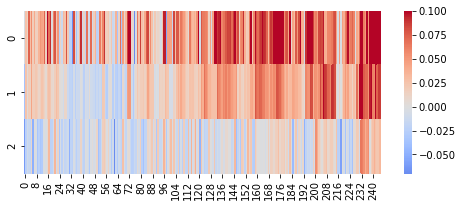

In [278]:
plt.figure(figsize=(8, 3))
sns.heatmap(clustered[['diff_alpha', 'diff_beta','diff_gamma']].values.T, cmap='coolwarm', center=0, vmax=0.1, vmin=-0.07)
x=426
# plt.plot([x, x], [-1, 10], color='k', lw=3)

In [260]:
# ATF5, STAT1, STAT3, JUN
# clustered.iloc[115:200].tf.tolist()